In [38]:
from leecarter import leecarter
import pandas as pd

import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [2]:
filename = 'death_rates2.txt'

mortality = pd.read_csv(filename, delim_whitespace=True)
mortality = mortality[mortality['Age'] != '110+']
mortality['Age'] = mortality['Age'].astype(int)
mortality['Year'] = mortality['Year'].astype(int)
mortality = mortality[mortality['Age'] <= 100]
mortality['Female_l'] = np.log(mortality['Female'].astype(float))
mortality['Male_l'] = np.log(mortality['Male'].astype(float))
mortality['Total_l'] = np.log(mortality['Total'].astype(float))
mortality = mortality[['Year', 'Age', 'Female_l', 'Male_l', 'Total_l']]
mortality

,Year,Age,Female_l,Male_l,Total_l
0,1958,0,-2.723920,-2.480397,-2.591788
1,1958,1,-5.352562,-5.291540,-5.320972
2,1958,2,-6.357324,-6.197751,-6.272237
3,1958,3,-6.732962,-6.527266,-6.622576
4,1958,4,-7.066751,-6.837297,-6.943382
...,...,...,...,...,...
6867,2019,96,-1.240243,-1.143835,-1.220129
6868,2019,97,-1.123130,-1.046502,-1.108135
6869,2019,98,-1.127061,-0.963167,-1.093425
6870,2019,99,-0.980088,-0.864780,-0.957410


In [39]:
# split train test
def fit_arima(matrix):
    d = []
    for a in range(5):
        for b in range(5):
            for c in range(5):
                try:
                    mod = ARIMA(matrix, order=(a,b,c))
                    res = mod.fit()
                    d.append([res.llf, a, b, c])
                except ConvergenceWarning:
                    pass

    print(d)
    return max(d)


def predict(matrix, column: str = 'Female_l', age = 65):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    fm_train = fm.iloc[:,0:round(np.shape(fm)[1]*2/3)]
    # fm_cross_val = fm.iloc[:,round(np.shape(fm)[1]*2/3):]
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    N = np.shape(fm)[0]
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)
    bxkt = S[0] * np.dot(U[:, 0].reshape(N, 1), V[0, :].reshape(T, 1).T)

    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    v, par1, par2, par3 = fit_arima(k_t)
    print(f'fit arima: {v, par1,par2,par3}')
    mod = ARIMA(k_t, order=(par1,par2,par3))
    # mod = ARIMA(k_t, order=(4,1,3))
    res = mod.fit()
    print(res.summary())

    pred = res.forecast(steps=21)
    print(pred)
    return np.exp(a_x[age] + b_x[age]*pred)

In [27]:
age = 65
column = 'Female_l'

In [28]:
vals = predict(mortality, column, age)

C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive pa

[[-167.66312422766316, 0, 0, 0], [-146.54780936972588, 0, 0, 1], [-131.07980055411736, 0, 0, 2], [-123.03094701275066, 0, 0, 3], [-116.17355552968321, 0, 0, 4], [-98.06883778698668, 0, 1, 0], [-98.0477183529452, 0, 1, 1], [-94.55069142801155, 0, 1, 2], [-94.51979041612194, 0, 1, 3], [-94.34236811942102, 0, 1, 4], [-108.57453425561125, 0, 2, 0], [-91.91319451336196, 0, 2, 1], [-89.87083897740841, 0, 2, 2], [-89.63249961162501, 0, 2, 3], [-87.47426810467041, 0, 2, 4], [-127.69830351869885, 0, 3, 0], [-108.10697993927418, 0, 3, 1], [-92.31865984834232, 0, 3, 2], [-89.7716625478964, 0, 3, 3], [-89.56875032950038, 0, 3, 4], [-146.23114118428163, 0, 4, 0], [-126.61336760018484, 0, 4, 1], [-109.10587577739037, 0, 4, 2], [-95.22265117933708, 0, 4, 3], [-92.73060757228357, 0, 4, 4], [-102.7671265222081, 1, 0, 0], [-102.74158404970736, 1, 0, 1], [-99.30086039773595, 1, 0, 2], [-99.26930803716407, 1, 0, 3], [-99.12844982165183, 1, 0, 4], [-98.03366636069154, 1, 1, 0], [-93.7039321539181, 1, 1, 1]

C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))
real_vals

,Year,Age,Female_l
65,1958,65,0.020337
176,1959,65,0.021817
287,1960,65,0.019643
398,1961,65,0.019515
509,1962,65,0.020237
...,...,...,...
6392,2015,65,0.010841
6503,2016,65,0.010374
6614,2017,65,0.010702
6725,2018,65,0.010264


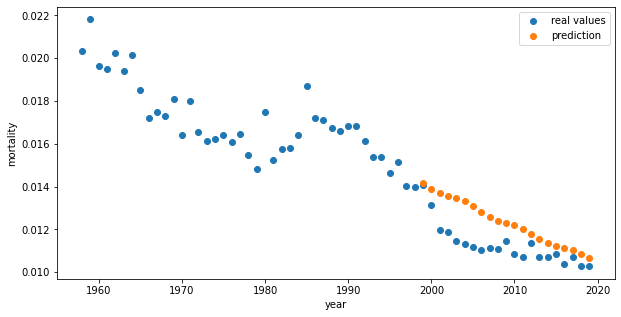

In [30]:
plt.figure(figsize=(10,5))
plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
plt.xlabel('year')
plt.ylabel('mortality')
plt.legend()
plt.savefig('figure.svg')

In [43]:
# jak cos nie styka
# split train test
def fit_arima_error(matrix):
    d = []
    for a in range(5):
        for b in range(2):
            for c in range(5):
                try:
                    mod = ARIMA(matrix, order=(a,b,c))
                    res = mod.fit()
                    d.append([res.llf, a, b, c])
                except ConvergenceWarning:
                    pass
    return d


def predict_error(matrix, column: str = 'Female_l', age = 65):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    fm_train = fm.iloc[:,0:round(np.shape(fm)[1]*2/3)]
    # fm_cross_val = fm.iloc[:,round(np.shape(fm)[1]*2/3):]
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    N = np.shape(fm)[0]
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)
    bxkt = S[0] * np.dot(U[:, 0].reshape(N, 1), V[0, :].reshape(T, 1).T)

    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    d = fit_arima_error(k_t)
    for d_i in d:
        mod = ARIMA(k_t, order=(d_i[1],d_i[2],d_i[3]))
        # mod = ARIMA(k_t, order=(4,1,3))
        res = mod.fit()
        pred = res.forecast(steps=21)
        real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
        real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))


        plt.figure(figsize=(10,5))
        plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
        plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
        plt.xlabel('year')
        plt.ylabel('mortality')
        plt.legend()
        plt.show()


In [45]:
age = 65
column = 'Male_l'
# vals = predict_error(mortality, column, age)


C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive pa

[[-112.15088027133137, 0, 0, 0], [-89.30898352319697, 0, 0, 1], [-71.39238715763278, 0, 0, 2], [-60.604046772633026, 0, 0, 3], [-56.431135547761144, 0, 0, 4], [-35.94647403889161, 0, 1, 0], [-35.503091016094935, 0, 1, 1], [-34.85866247175966, 0, 1, 2], [-34.73777978576339, 0, 1, 3], [-32.147531828543464, 0, 1, 4], [-45.03222264122037, 0, 2, 0], [-29.27066108074094, 0, 2, 1], [-27.983189671645825, 0, 2, 2], [-27.641608708875143, 0, 2, 3], [-27.34102633490344, 0, 2, 4], [-64.8862810402836, 0, 3, 0], [-46.19829806177408, 0, 3, 1], [-32.478526689954165, 0, 3, 2], [-31.539547682479782, 0, 3, 3], [-31.359228480232066, 0, 3, 4], [-84.13806644163853, 0, 4, 0], [-65.46483612421282, 0, 4, 1], [-48.88557809155118, 0, 4, 2], [-37.237792967405575, 0, 4, 3], [-36.610169869076415, 0, 4, 4], [-39.23560029449478, 1, 0, 0], [-38.77710587400632, 1, 0, 1], [-38.143281756106475, 1, 0, 2], [-38.040457770351885, 1, 0, 3], [-35.45656078054788, 1, 0, 4], [-35.31856092295754, 1, 1, 0], [-29.631580731508024, 1, 

C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\AppData\Local\Temp\ipykernel_14552\1635334433.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(a_x[age] + b_x[age]*pred)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   41
Model:                 ARIMA(2, 4, 2)   Log Likelihood                 -18.531
Date:                Fri, 10 Jun 2022   AIC                             47.062
Time:                        14:49:08   BIC                             55.117
Sample:                             0   HQIC                            49.902
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0008   1.98e-08   4.13e+04      0.000       0.001       0.001
ar.L2          0.9992   1.89e-05   5.28e+04      0.000       0.999       0.999
ma.L1         -1.9998      0.009   -222.342      0.0

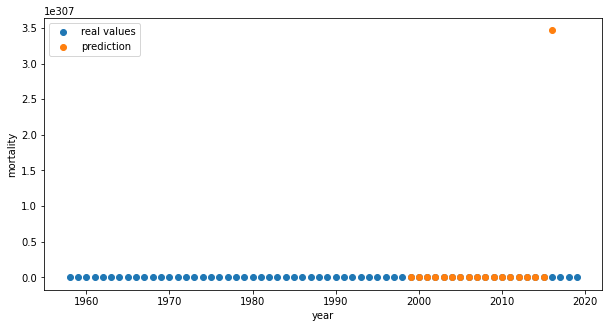

In [50]:
age = 65
column = 'Female_l'
vals = predict(mortality, column, age)
real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))
plt.figure(figsize=(10,5))
plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
plt.xlabel('year')
plt.ylabel('mortality')
plt.legend()
plt.savefig('figure.svg')